In [ ]:
from __future__ import annotations

import pandas as pd
import numpy as np
import sys
import traceback
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from typing import Literal, Final, List, TypeVar, Dict, Tuple, Any, Optional, Iterable, Union, NoReturn
import sklearn
import dataclasses
import os



import pickle

import dill

In [ ]:
dataset: Literal["ihdp","jobs"] = "jobs"

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#print(sns.plotting_context())

sns.set_theme(style="darkgrid",context="paper")

import matplotlib.style
if "seaborn-darkgrid" in matplotlib.style.available:
    matplotlib.style.use("seaborn-darkgrid")

%matplotlib inline

In [ ]:
from assignment2.a2_utils.seed_utils import *

from assignment2.a2_utils.misc_utils import *

import assignment2.a2_utils.seed_utils as seed_utils
import assignment2.a2_utils.misc_utils as misc_utils
import assignment2.a2_utils.metric_utils as metric_utils
import assignment2.a2_utils.dataframe_utils as df_utils
import assignment2.a2_utils.simple_learner_utils as slearner

import econml


""

''

# JOBS dataset processing


In [ ]:

jobs_full: pd.DataFrame = df_utils.turn_01_columns_into_int(
    pd.read_csv(f"{dataset}_full.csv")
)
"The full JOBS dataset as a dataframe"

jobs_full.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,t,y,e,tcf
0,-0.614282,1.464727,0,0,1,0,2.393250,2.746196,-0.653311,-0.656913,...,2.462337,2.937244,0,0,2.843909,0,0,1,0,1
1,-0.802463,0.101835,0,0,1,0,0.109885,0.498271,-0.785284,-0.743407,...,-0.177193,0.082537,0,0,0.038422,0,0,1,0,1
2,-0.896553,-0.238888,1,0,1,1,-0.085212,-0.148097,-0.847312,-0.781606,...,-0.286221,-0.303615,0,0,-0.191304,0,0,1,0,1
3,-0.896553,-0.238888,0,0,0,1,0.405581,0.325594,-0.847312,-0.781606,...,0.023020,-0.039630,0,0,0.173108,0,0,1,1,1
4,0.138440,-1.601779,1,0,1,1,-0.722531,-0.212734,-0.019840,-0.156019,...,-0.514563,-0.331552,0,0,-0.779227,0,0,1,0,1


In [ ]:
jobs_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      3212 non-null   float64
 1   x1      3212 non-null   float64
 2   x2      3212 non-null   uint8  
 3   x3      3212 non-null   uint8  
 4   x4      3212 non-null   uint8  
 5   x5      3212 non-null   uint8  
 6   x6      3212 non-null   float64
 7   x7      3212 non-null   float64
 8   x8      3212 non-null   float64
 9   x9      3212 non-null   float64
 10  x10     3212 non-null   float64
 11  x11     3212 non-null   float64
 12  x12     3212 non-null   float64
 13  x13     3212 non-null   uint8  
 14  x14     3212 non-null   uint8  
 15  x15     3212 non-null   float64
 16  x16     3212 non-null   uint8  
 17  t       3212 non-null   uint8  
 18  y       3212 non-null   uint8  
 19  e       3212 non-null   uint8  
 20  tcf     3212 non-null   uint8  
dtypes: float64(10), uint8(11)
memory usag

In [ ]:
dfm: df_utils.DataframeManager = df_utils.DataframeManager.make(
    dataset_name = dataset,
    the_df = jobs_full,
    test_proportion = 0.1,
    split_randomstate = rng_state(),
    columns_for_training_stratification= ["t","e","y"],
    t_column = "t",
    t_cf_column = "tcf",
    y_column = "y",
    e_column = "e",

)


In [ ]:
dfm.save_self()

pickling self as \jobs\jobs DataframeManager.pickle...
pickled!


True

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection._validation import NotFittedError
from sklearn.base import ClassifierMixin, TransformerMixin
from sklearn.linear_model import ARDRegression, SGDClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.metrics import r2_score, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.utils import Bunch
from math import inf

set_config(display="diagram")



# Part 3 - Simple Learners

In [ ]:
%%time

rf_min_samples = [2,4,6,8]
rf_min_impurity_decrease =  [0, *np.geomspace(0.00001, 0.15,5)[1:]]
rf_max_features = [None,"sqrt","log2",1,2]
rf_ccp_alpha =  [0, *np.geomspace(0.00001, 0.15,5)[1:]]
rf_n_estimators = [50,100,150,200]

rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features":rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)


-- 10-fold attempt 1/4 start --
max: 50, min: 7, factor: 8
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 500
n_resources: 7
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
----------
iter: 1
n_candidates: 63
n_resources: 7
Fitting 10 folds for each of 63 candidates, totalling 630 fits
----------
iter: 2
n_candidates: 8
n_resources: 7
Fitting 10 folds for each of 8 candidates, totalling 80 fits
best from this iteration: 
GridSearchResults summary Random Forest simple jobs
	test score:	0.05141334081503812
	train score:0.08019262782375895
	y score:	0.11880291216390815
	abs ATT:	2.6041513170924935
	p. risk:	0.008949499254208404

--- 1/4 END ---
-- 10-fold attempt 2/4 start --
max: 100, min: 1, factor: 10
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 100
aggressive_elimination: True
factor: 10


In [ ]:

rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_searched
)


In [ ]:

print(rf_simple_best.info)



rf_simple_best.best_estimator_


GridSearchResults summary Random Forest simple jobs
	test score:	0.05141334081503812
	train score:0.069318011202359
	y score:	0.11880291216390815
	abs ATT:	0.009205783323430375
	p. risk:	0.0
	best params:
		estimator__ccp_alpha : 0.00011066819197003216
		estimator__max_features : None
		estimator__min_impurity_decrease : 0.0012247448713915891
		estimator__min_samples_split : 2
		estimator__n_estimators : 100


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestClassifier(ccp_alpha=0.00011066819197003216,
                                         max_features=None,
                                         min_impurity_decrease=0.0012247448713915891,
                                         random_state=42))])

In [ ]:
rf_simple_best.save_me()

Pickling results to: \jobs\jobs Random Forest simple results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Random Forest simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Random Forest simple feature importances.pdf


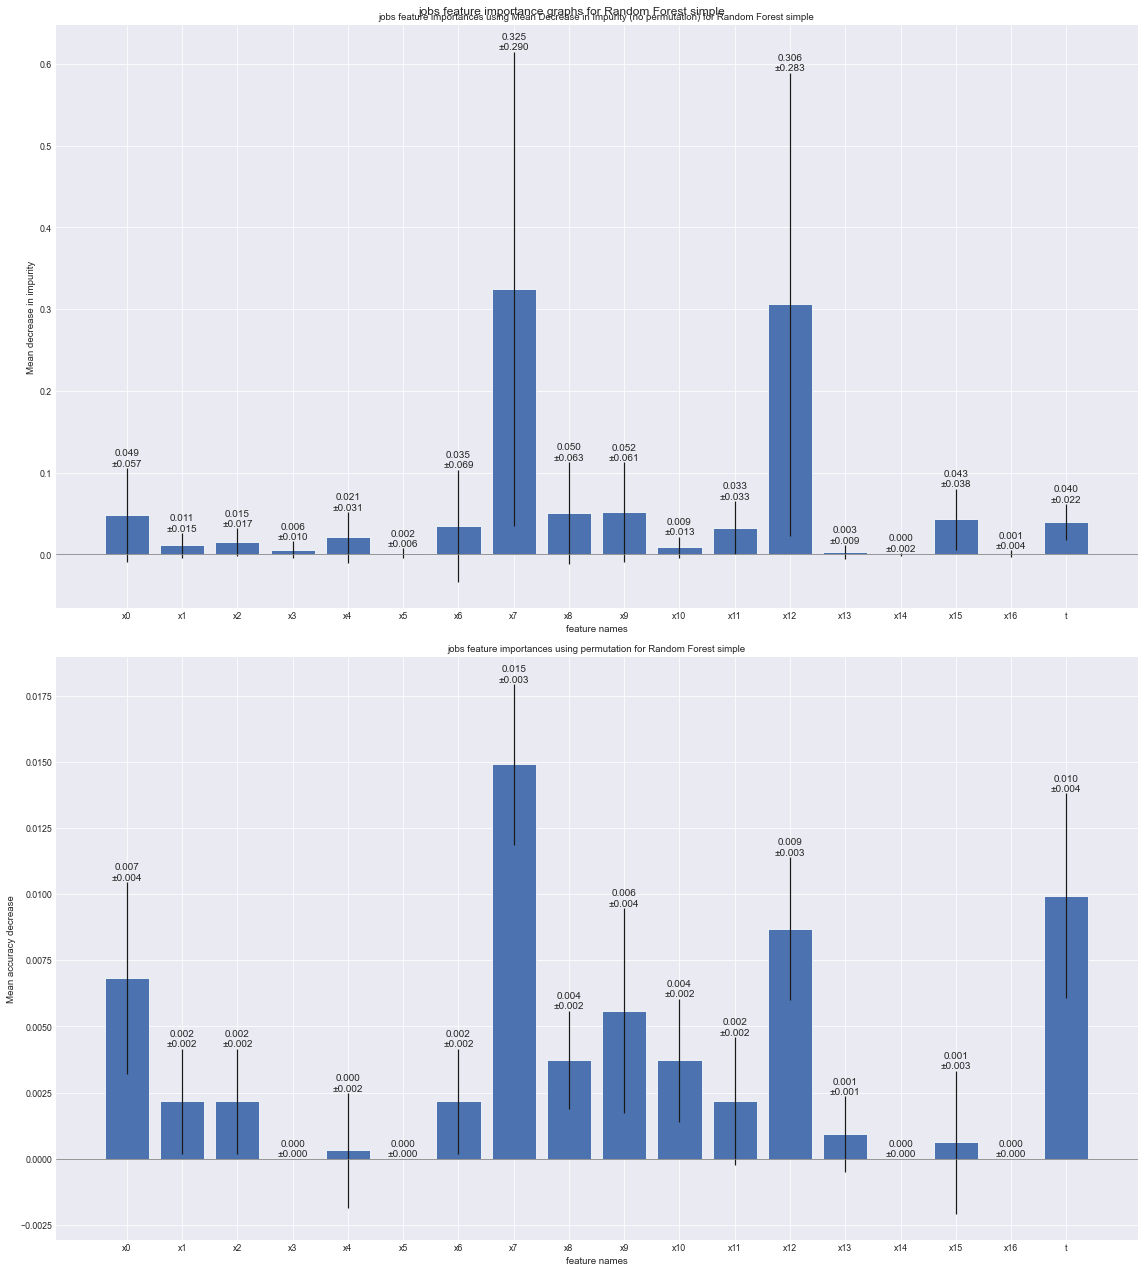

In [ ]:
rf_simple_best.importance_plotter().show()

In [ ]:
%%time

ard_iter: List[int] = [200, 250, 300]
ard_tol: List[float] = [1e-2, 1e-3, 1e-4]
ard_alpha_lambda: List[float] = [1e-5, 1e-6, 1e-7]
ard_thresh_lambda: List[float] = [1e3, 1e4, 1e5]



ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1" : ard_alpha_lambda,
        "estimator__alpha_2" : ard_alpha_lambda,
        "estimator__lambda_1" : ard_alpha_lambda,
        "estimator__lambda_2" : ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_iter",
    resource_param_values=ard_iter
)

-- 10-fold attempt 1/3 start --
max: 200, min: 14, factor: 15
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 14
max_resources_: 200
aggressive_elimination: True
factor: 15
----------
iter: 0
n_candidates: 729
n_resources: 14
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
----------
iter: 1
n_candidates: 49
n_resources: 14
Fitting 10 folds for each of 49 candidates, totalling 490 fits
----------
iter: 2
n_candidates: 4
n_resources: 14
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary ARD simple jobs
	test score:	0.19529670053455017
	train score:0.2168550319378632
	y score:	0.22053302642612627
	abs ATT:	0.007023840941684956
	p. risk:	0.272259591388771

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 250, min: 16, factor: 16
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 16
max_resources_: 250
aggressive_elimination: True
factor: 16
-

In [ ]:

ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_searched
)




In [ ]:

print(ard_simple_best.info)


ard_simple_best.best_estimator_


GridSearchResults summary ARD simple jobs
	test score:	0.19529670053455017
	train score:0.2168550319378632
	y score:	0.22053302642612627
	abs ATT:	0.007023840941684956
	p. risk:	0.272259591388771
	best params:
		estimator__alpha_1 : 1e-05
		estimator__alpha_2 : 1e-07
		estimator__lambda_1 : 1e-07
		estimator__lambda_2 : 1e-06
		estimator__threshold_lambda : 100000.0
		estimator__tol : 0.01
		estimator__n_iter : 14


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  ARDRegression(alpha_1=1e-05, alpha_2=1e-07, lambda_1=1e-07,
                                n_iter=14, threshold_lambda=100000.0,
                                tol=0.01))])

In [ ]:
ard_simple_best.save_me()

Pickling results to: \jobs\jobs ARD simple results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs ARD simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs ARD simple feature importances.pdf


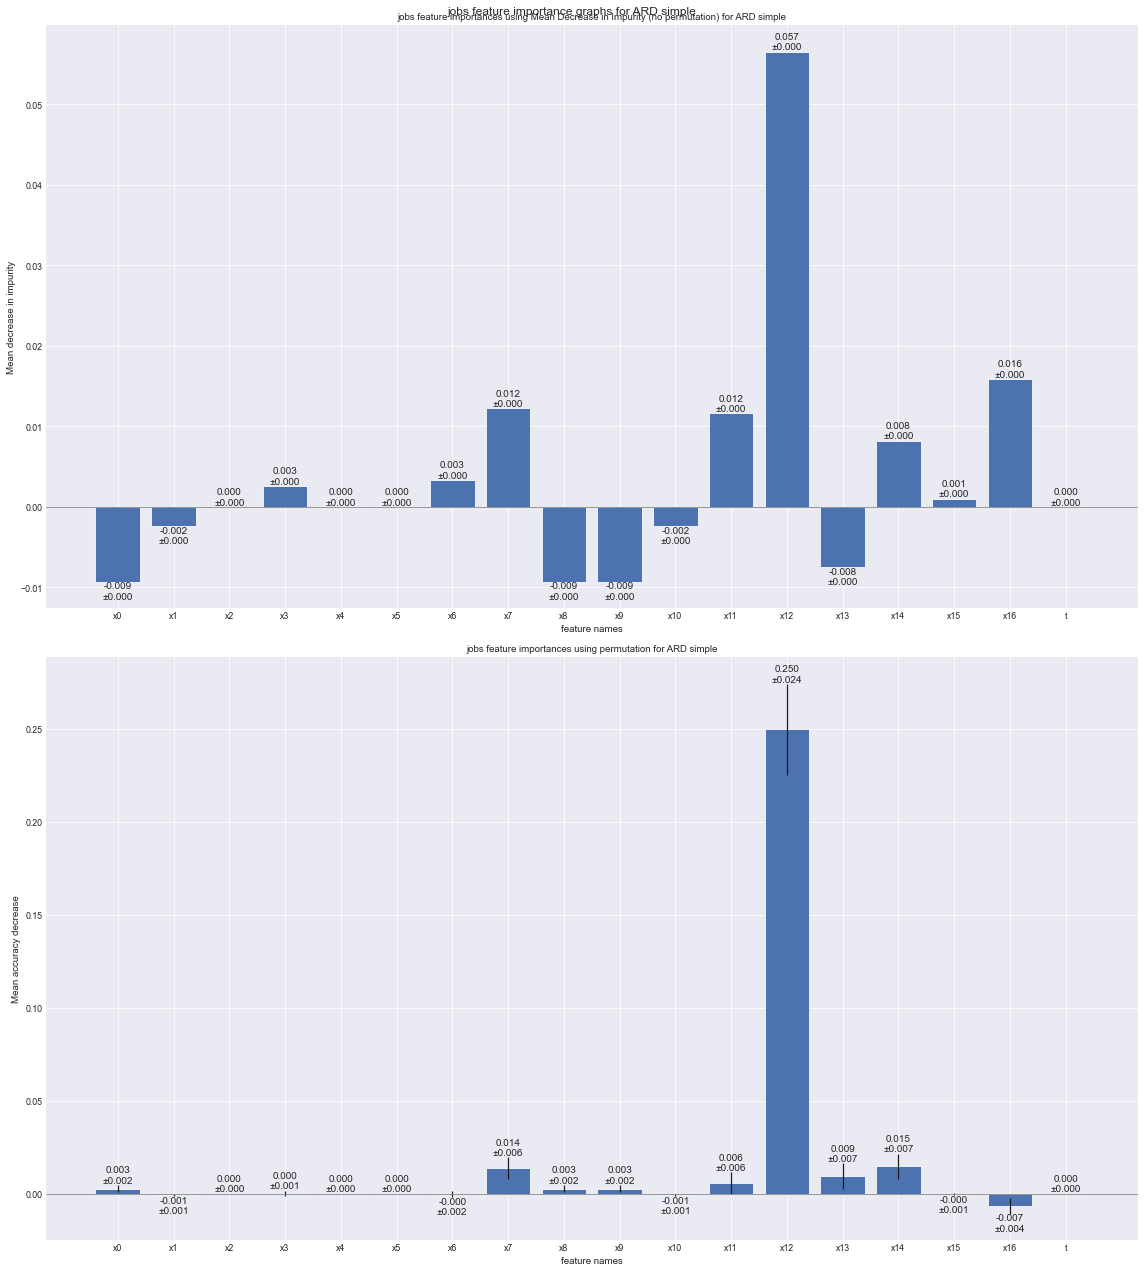

In [ ]:
ard_simple_best.importance_plotter().show()

In [ ]:
%%time

sgd_max_iter: List[int] = [500,1000,1500]
sgd_alpha: List[float] = [0.001, 0.0001, 0.00001]
sgd_learning_rate: List[str] =  ["constant","optimal","invscaling","adaptive"]
sgd_power_t: List[float] = [0.25,0.5,0.75]
sgd_l1_ratio: List[float] = [0, 0.15, 0.5, 0.85, 1]

sgd_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)

-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 180
n_resources: 22
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
----------
iter: 1
n_candidates: 8
n_resources: 22
Fitting 10 folds for each of 8 candidates, totalling 80 fits
best from this iteration: 
GridSearchResults summary sgd simple jobs
	test score:	-0.10668443571578878
	train score:-0.2672657526271284
	y score:	-0.05938929673369486
	abs ATT:	0.0036918201624084324
	p. risk:	0.007058823529411784

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 32
max_resources_: 1000
aggressive_elimination: True
factor: 32
----------
iter: 0
n_candidates: 180
n_resources: 32
Fitting 10 folds for each of 180 candidates, totalling

In [ ]:

sgd_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_searched
)



In [ ]:

print(sgd_simple_best.info)

sgd_simple_best.best_estimator_


GridSearchResults summary sgd simple jobs
	test score:	-0.10668443571578878
	train score:-0.2672657526271284
	y score:	-0.05938929673369486
	abs ATT:	0.0036918201624084324
	p. risk:	0.007058823529411784
	best params:
		estimator__alpha : 0.0001
		estimator__l1_ratio : 1
		estimator__learning_rate : optimal
		estimator__power_t : 0.25
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDClassifier(early_stopping=True, l1_ratio=1, max_iter=22,
                                penalty='elasticnet', power_t=0.25,
                                random_state=42))])

In [ ]:
sgd_simple_best.save_me()

Pickling results to: \jobs\jobs sgd simple results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs sgd simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs sgd simple feature importances.pdf


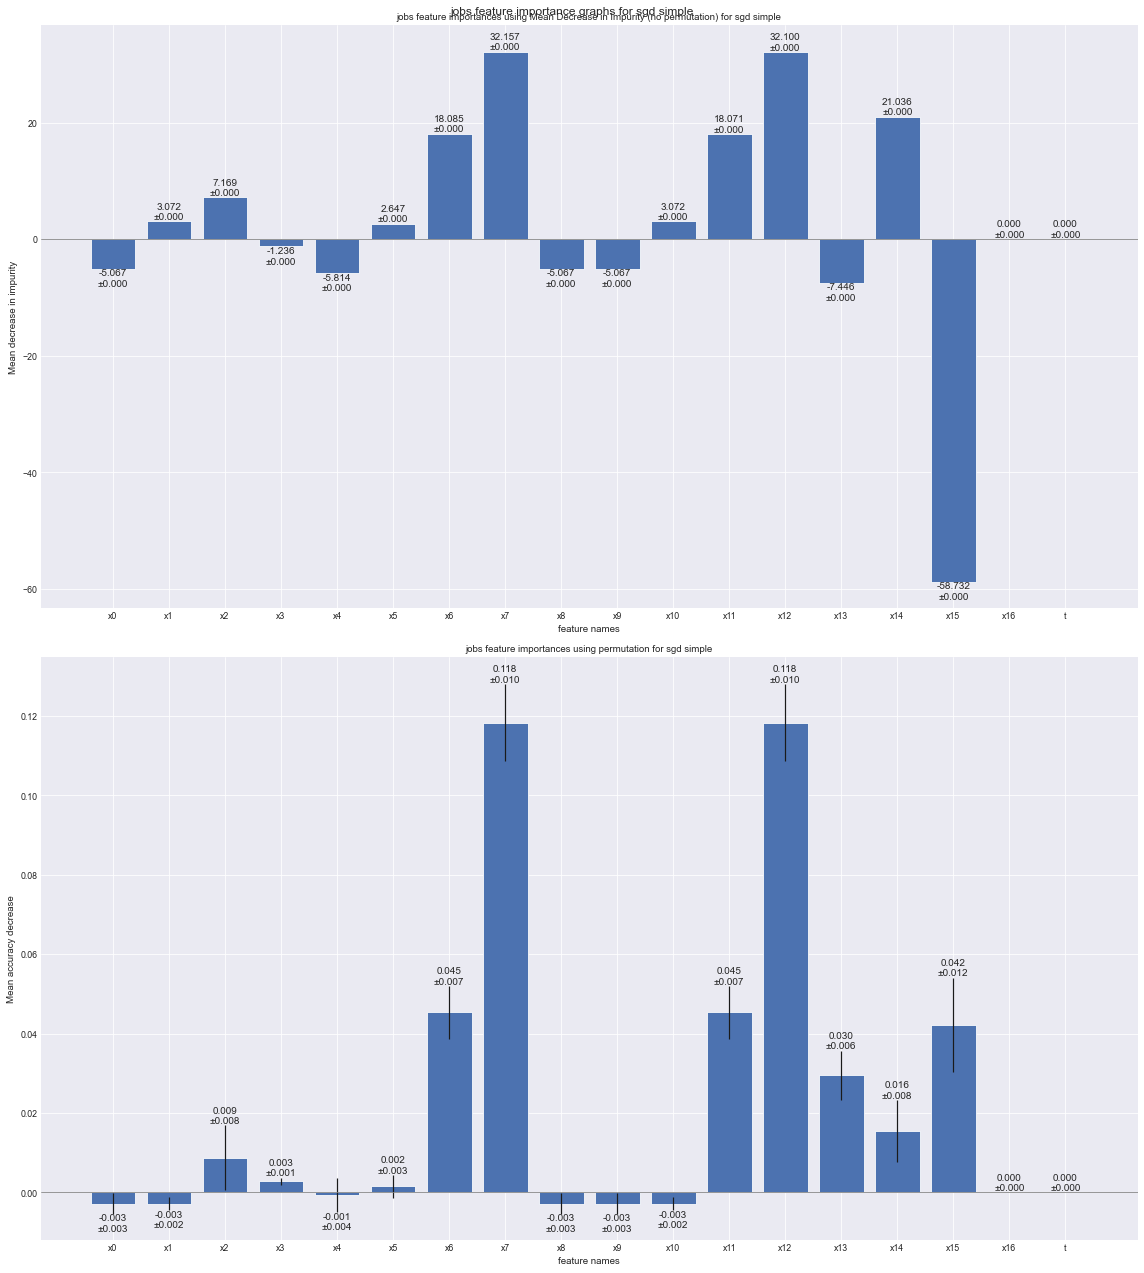

In [ ]:
sgd_simple_best.importance_plotter().show()

In [ ]:
%%time

adaboost_estimators: List[int] = [25, 50, 75]
adaboost_learn_rate: List[float] = [0.8, 0.9, 1.0, 1.1, 1.2]

ada_rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state = seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 40
n_resources: 1
Fitting 10 folds for each of 40 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 8
n_resources: 5
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest simple jobs
	test score:	0.02882794416777712
	train score:0.034015801097927824
	y score:	0.8169258127764352
	abs ATT:	27.493071895424837
	p. risk:	0.2596913108542681

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 50, min: 7, factor: 8
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
--

In [ ]:

ada_rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_searched
)



In [ ]:

print(ada_rf_simple_best.info)



ada_rf_simple_best.best_estimator_


GridSearchResults summary Adaboost Random Forest simple jobs
	test score:	0.09658413410956013
	train score:0.06396129072189612
	y score:	0.711963278768258
	abs ATT:	26.62369578134284
	p. risk:	0.22802157748942997
	best params:
		estimator__base_estimator : RandomForestClassifier(ccp_alpha=0.0012247448713915891, max_features=2,
                       min_impurity_decrease=0.00011066819197003216,
                       min_samples_split=4, n_estimators=14, random_state=42)
		estimator__learning_rate : 0.8
		estimator__n_estimators : 9


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostClassifier(base_estimator=RandomForestClassifier(ccp_alpha=0.0012247448713915891,
                                                                           max_features=2,
                                                                           min_impurity_decrease=0.00011066819197003216,
                                                                           min_samples_split=4,
                                                                           n_estimators=14,
                                                                           random_state=42),
                                     learning_rate=0.8, n_estimators=9,
                                     random_state=42))])

In [ ]:
ada_rf_simple_best.save_me()

Pickling results to: \jobs\jobs Adaboost Random Forest simple results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Adaboost Random Forest simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Adaboost Random Forest simple feature importances.pdf


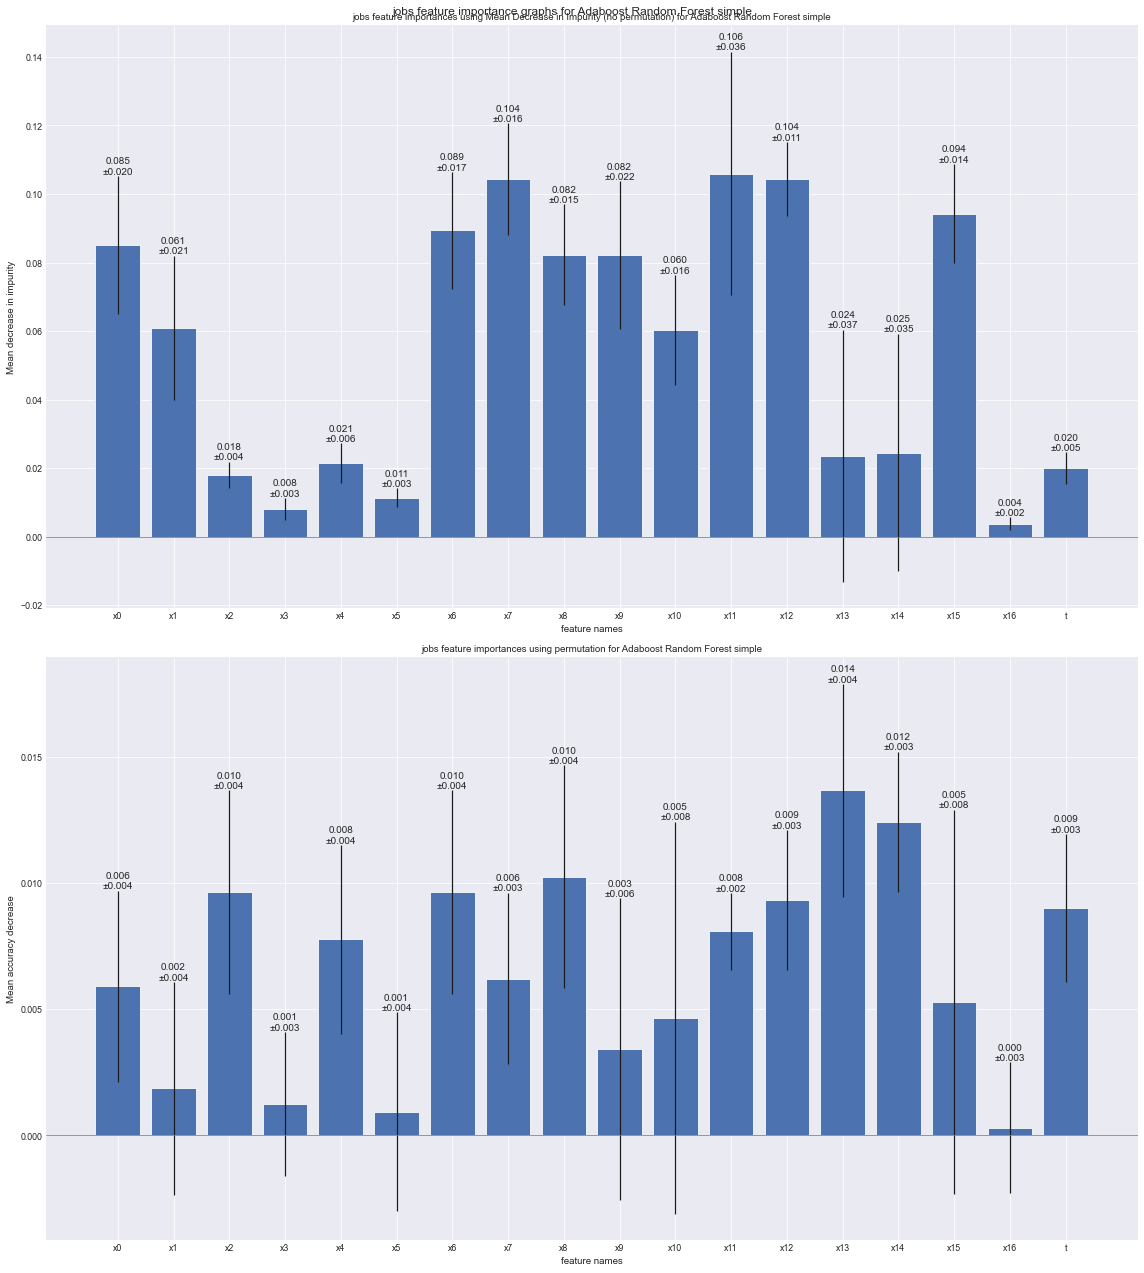

In [ ]:
ada_rf_simple_best.importance_plotter().show()

In [ ]:


all_simple_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_best,
    ard_simple_best,
    sgd_simple_best,
    ada_rf_simple_best
]

all_simple_best.sort(reverse=True)


In [ ]:
for bc in all_simple_best:
    print(bc.summary_info)

print("")

GridSearchResults summary ARD simple jobs
	test score:	0.19529670053455017
	train score:0.2168550319378632
	y score:	0.22053302642612627
	abs ATT:	0.007023840941684956
	p. risk:	0.272259591388771
GridSearchResults summary Adaboost Random Forest simple jobs
	test score:	0.09658413410956013
	train score:0.06396129072189612
	y score:	0.711963278768258
	abs ATT:	26.62369578134284
	p. risk:	0.22802157748942997
GridSearchResults summary Random Forest simple jobs
	test score:	0.05141334081503812
	train score:0.069318011202359
	y score:	0.11880291216390815
	abs ATT:	0.009205783323430375
	p. risk:	0.0
GridSearchResults summary sgd simple jobs
	test score:	-0.10668443571578878
	train score:-0.2672657526271284
	y score:	-0.05938929673369486
	abs ATT:	0.0036918201624084324
	p. risk:	0.007058823529411784



In [ ]:
best_simple_est: slearner.PPipeline = max(all_simple_best).best_estimator_

# Part 4 - Inverse Propensity Weights


### attempting to find the likelihood of individuals being NOT being included in the treatment group

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time

rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split":rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha": rf_ccp_alpha,
        "estimator__class_weight": ["balanced", "balanced subsample"],
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
)

-- 10-fold attempt 1/4 start --
max: 50, min: 7, factor: 8
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 1000
n_resources: 7
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
----------
iter: 1
n_candidates: 125
n_resources: 7
Fitting 10 folds for each of 125 candidates, totalling 1250 fits
----------
iter: 2
n_candidates: 16
n_resources: 7
Fitting 10 folds for each of 16 candidates, totalling 160 fits
----------
iter: 3
n_candidates: 2
n_resources: 7
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Random Forest IPSW jobs
	test score:	0.8766891891891893
	train score:0.88912023980134
	y score:	0.8931198780255384

--- 1/4 END ---
-- 10-fold attempt 2/4 start --
max: 100, min: 1, factor: 10
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_res

In [ ]:

rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_ipsw_searched
)



In [ ]:
print(rf_ipsw_best.info)

rf_ipsw_best.best_estimator_

GridSearchResults summary Random Forest IPSW jobs
	test score:	0.8905275467775469
	train score:0.8929028594269447
	y score:	0.9001524680769964
	best params:
		estimator__ccp_alpha : 0.0012247448713915891
		estimator__class_weight : balanced
		estimator__max_features : 2
		estimator__min_impurity_decrease : 0
		estimator__min_samples_split : 6
		estimator__n_estimators : 14


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestClassifier(ccp_alpha=0.0012247448713915891,
                                         class_weight='balanced',
                                         max_features=2,
                                         min_impurity_decrease=0,
                                         min_samples_split=6, n_estimators=14,
                                         random_state=42))])

In [ ]:
rf_ipsw_best.save_me()

Pickling results to: \jobs\jobs Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Random Forest IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Random Forest IPSW feature importances.pdf


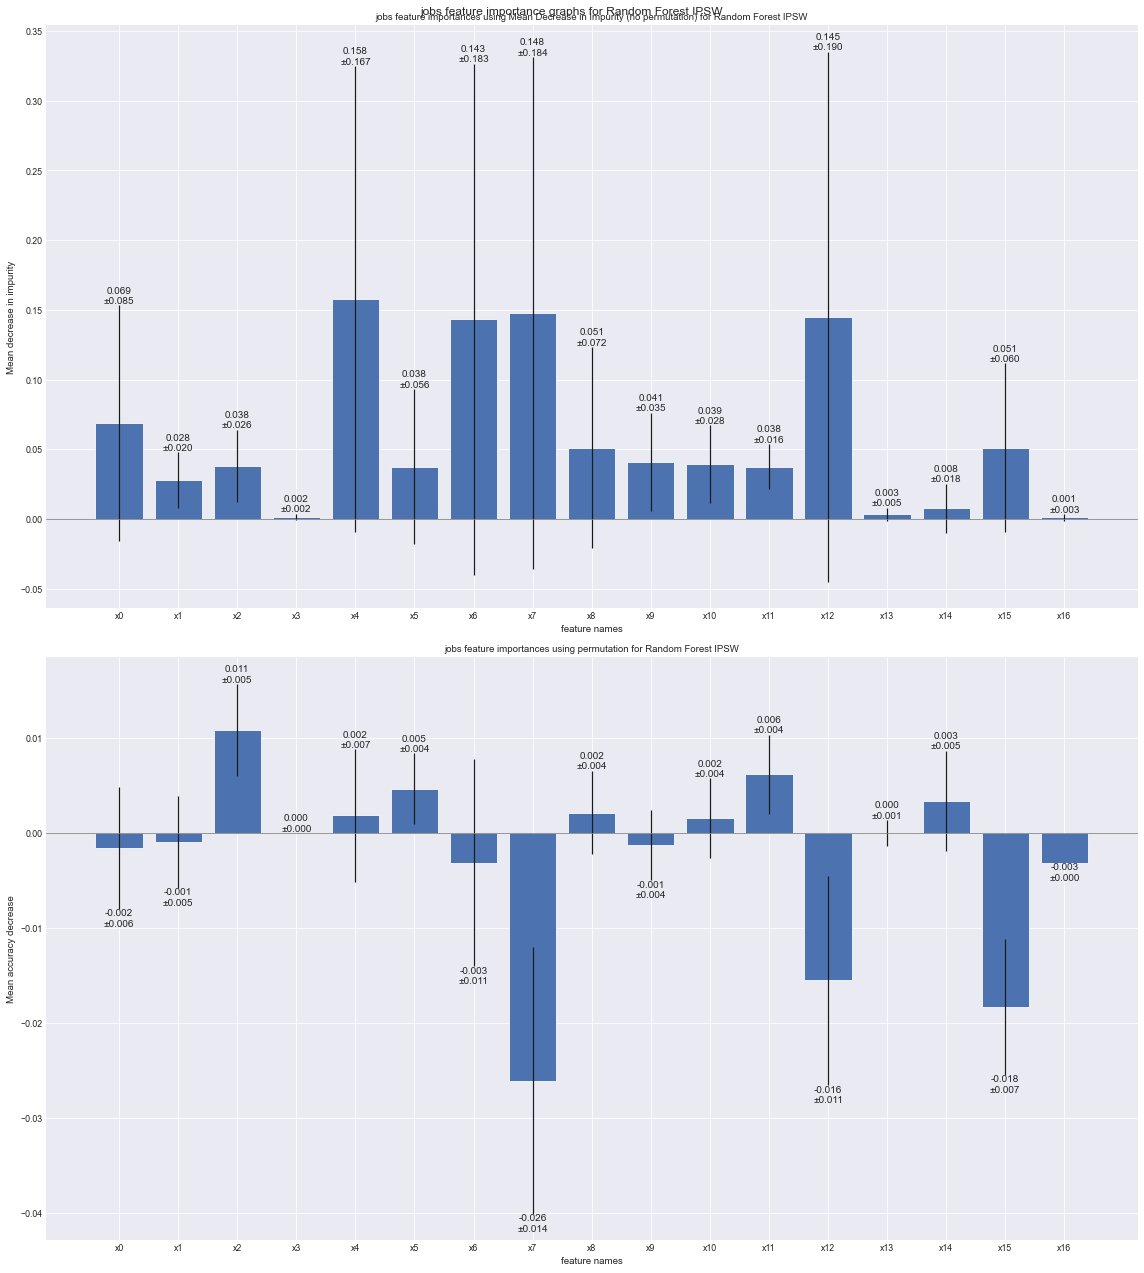

In [ ]:
rf_ipsw_best.importance_plotter().show()

In [ ]:
%%time

# note: ridge does not support predict_proba, unusable, replaced with SGDClassifier.

sgd_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        n_jobs=-1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        loss="log",
        penalty="elasticnet"
    ),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio,
        "estimator__class_weight": ["balanced", None]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="sgd IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)


-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 360
n_resources: 22
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
----------
iter: 1
n_candidates: 16
n_resources: 22
Fitting 10 folds for each of 16 candidates, totalling 160 fits
best from this iteration: 
GridSearchResults summary sgd IPSW jobs
	test score:	0.887279106029106
	train score:0.8433803764844827
	y score:	0.801956673654787

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 32
max_resources_: 1000
aggressive_elimination: True
factor: 32
----------
iter: 0
n_candidates: 360
n_resources: 32
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
----------
iter: 1
n_candidates: 12
n_resources: 32
Fittin

In [ ]:
sgd_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_ipsw_searched
)

In [ ]:

print(sgd_ipsw_best.info)

sgd_ipsw_best.best_estimator_

GridSearchResults summary sgd IPSW jobs
	test score:	0.887279106029106
	train score:0.8433803764844827
	y score:	0.801956673654787
	best params:
		estimator__alpha : 0.001
		estimator__class_weight : balanced
		estimator__l1_ratio : 1
		estimator__learning_rate : optimal
		estimator__power_t : 0.75
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDClassifier(alpha=0.001, class_weight='balanced',
                                early_stopping=True, l1_ratio=1, loss='log',
                                max_iter=22, n_jobs=-1, penalty='elasticnet',
                                power_t=0.75, random_state=42))])

In [ ]:

sgd_ipsw_best.save_me()

Pickling results to: \jobs\jobs sgd IPSW results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs sgd IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs sgd IPSW feature importances.pdf


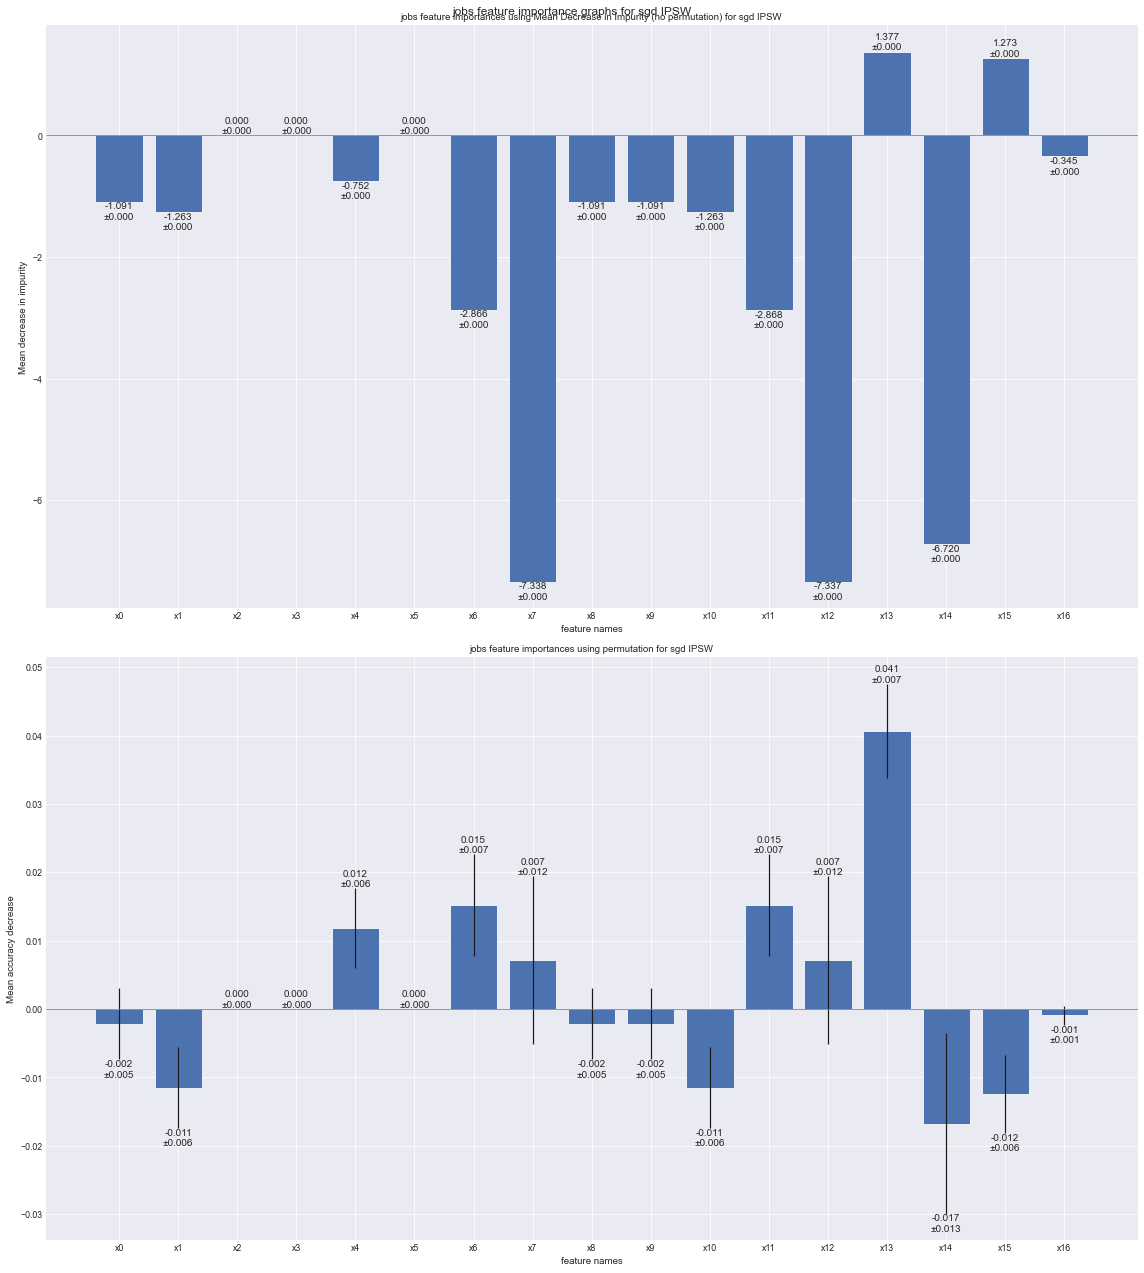

In [ ]:

sgd_ipsw_best.importance_plotter().show()

In [ ]:
%%time

ada_rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state = seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_ipsw_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Adaboost Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 40
n_resources: 1
Fitting 10 folds for each of 40 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 8
n_resources: 5
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest IPSW jobs
	test score:	0.8841606029106029
	train score:0.8897063032460505
	y score:	0.9536624102661838

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 50, min: 7, factor: 8
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 40
n_resources: 7
Fitting 10 fol

In [ ]:
ada_rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_ipsw_searched
)

In [ ]:

print(ada_rf_ipsw_best.info)

ada_rf_ipsw_best.best_estimator_

GridSearchResults summary Adaboost Random Forest IPSW jobs
	test score:	0.8914371101871102
	train score:0.8962637584939508
	y score:	0.9273235499650593
	best params:
		estimator__base_estimator : RandomForestClassifier(ccp_alpha=0, class_weight='balanced', max_features=2,
                       min_impurity_decrease=0.0012247448713915891,
                       min_samples_split=4, random_state=42)
		estimator__learning_rate : 1.0
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostClassifier(base_estimator=RandomForestClassifier(ccp_alpha=0,
                                                                           class_weight='balanced',
                                                                           max_features=2,
                                                                           min_impurity_decrease=0.0012247448713915891,
                                                                           min_samples_split=4,
                                                                           random_state=42),
                                     n_estimators=7, random_state=42))])

In [ ]:

ada_rf_ipsw_best.save_me()

Pickling results to: \jobs\jobs Adaboost Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Adaboost Random Forest IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Adaboost Random Forest IPSW feature importances.pdf


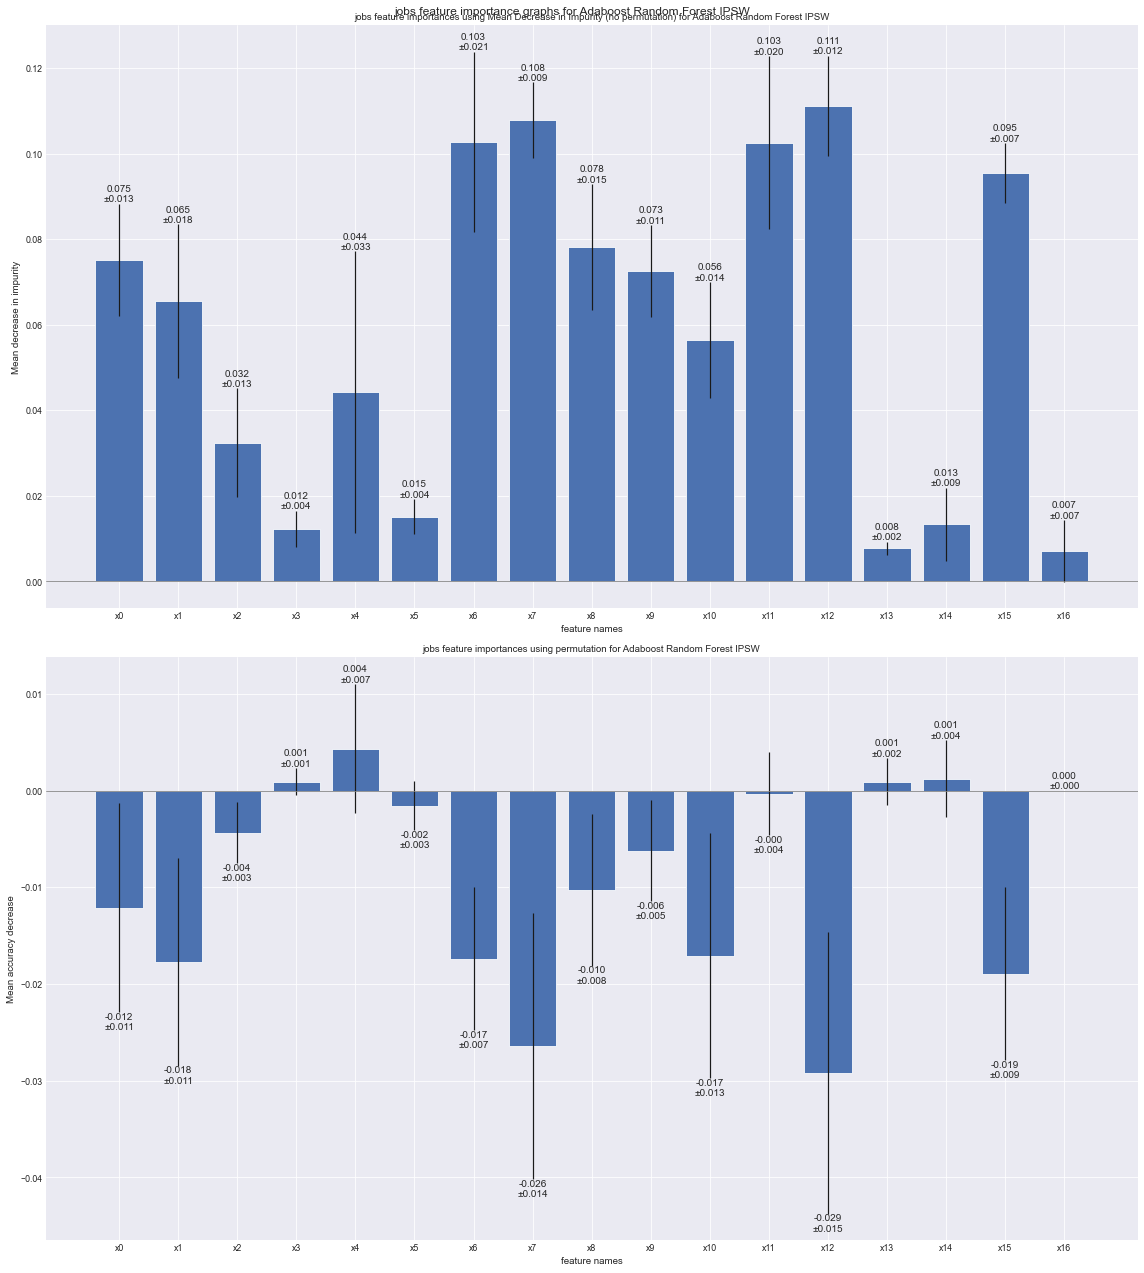

In [ ]:

ada_rf_ipsw_best.importance_plotter().show()

In [ ]:
all_ipsw_clf_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_ipsw_best,
    sgd_ipsw_best,
    ada_rf_ipsw_best
]

all_ipsw_clf_best.sort(reverse=True)

for bc in all_ipsw_clf_best:
    print(bc.summary_info)

print("")

GridSearchResults summary Adaboost Random Forest IPSW jobs
	test score:	0.8914371101871102
	train score:0.8962637584939508
	y score:	0.9273235499650593
GridSearchResults summary Random Forest IPSW jobs
	test score:	0.8905275467775469
	train score:0.8929028594269447
	y score:	0.9001524680769964
GridSearchResults summary sgd IPSW jobs
	test score:	0.887279106029106
	train score:0.8433803764844827
	y score:	0.801956673654787



In [ ]:
best_ipsw_predictor: slearner.PPipeline = max(all_ipsw_clf_best).best_estimator_

ipsw_calc: slearner.IpswWrapper = slearner.IpswWrapper.make(
    best_ipsw_predictor,
    dataset_name=dataset
)

ipsw_calc.save_me()


### And now using these weights to redo the earlier simple estimators

In [ ]:
%%time


rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    sample_weights=ipsw_calc,
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)

-- 10-fold attempt 1/4 start --
max: 50, min: 7, factor: 8
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 500
n_resources: 7
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
----------
iter: 1
n_candidates: 63
n_resources: 7
Fitting 10 folds for each of 63 candidates, totalling 630 fits
----------
iter: 2
n_candidates: 8
n_resources: 7
Fitting 10 folds for each of 8 candidates, totalling 80 fits
best from this iteration: 
GridSearchResults summary Random Forest simple with IPSW jobs
	test score:	0.05141334081503812
	train score:0.08019262782375895
	y score:	0.11880291216390815
	abs ATT:	2.6041513170924935
	p. risk:	0.008949499254208404

--- 1/4 END ---
-- 10-fold attempt 2/4 start --
max: 100, min: 1, factor: 10
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 100
aggressive_elimination: True
f

In [ ]:

rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_ipsw_searched
)

In [ ]:

print(rf_simple_ipsw_best.info)

rf_simple_ipsw_best.best_estimator_

GridSearchResults summary Random Forest simple with IPSW jobs
	test score:	0.05141334081503812
	train score:0.069318011202359
	y score:	0.11880291216390815
	abs ATT:	0.009205783323430375
	p. risk:	0.0
	best params:
		estimator__ccp_alpha : 0.00011066819197003216
		estimator__max_features : None
		estimator__min_impurity_decrease : 0.0012247448713915891
		estimator__min_samples_split : 2
		estimator__n_estimators : 100


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestClassifier(ccp_alpha=0.00011066819197003216,
                                         max_features=None,
                                         min_impurity_decrease=0.0012247448713915891,
                                         random_state=42))])

In [ ]:

rf_simple_ipsw_best.save_me()

Pickling results to: \jobs\jobs Random Forest simple with IPSW results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Random Forest simple with IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Random Forest simple with IPSW feature importances.pdf


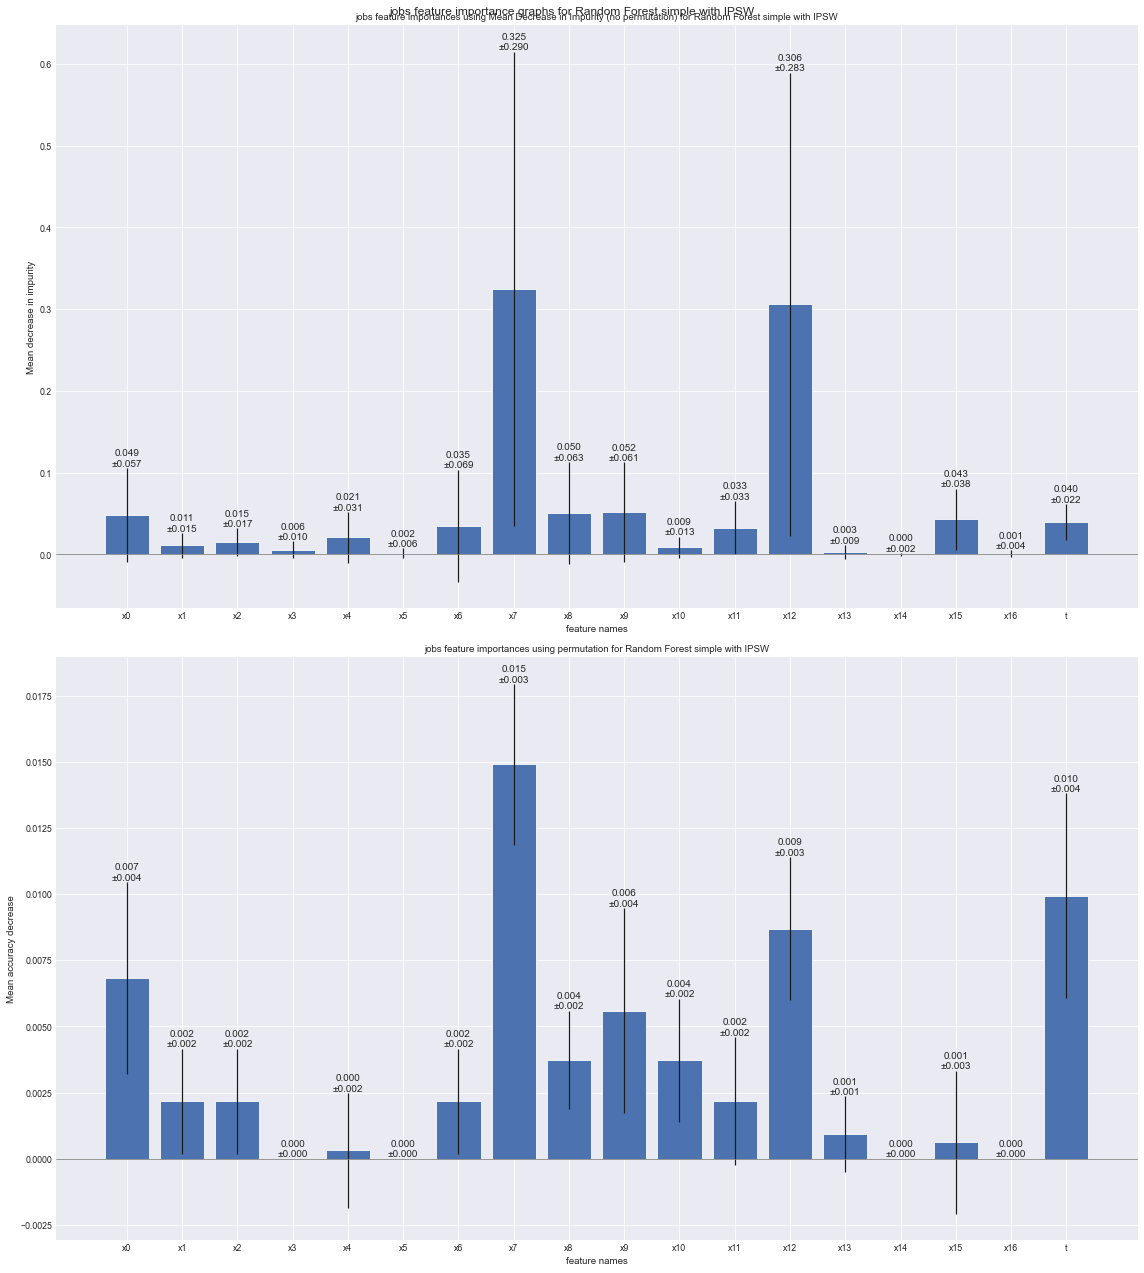

In [ ]:
rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time


ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1": ard_alpha_lambda,
        "estimator__alpha_2": ard_alpha_lambda,
        "estimator__lambda_1": ard_alpha_lambda,
        "estimator__lambda_2": ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__n_iter",
    sample_weights=ipsw_calc,
    resource_param_values=ard_iter
)


-- 10-fold attempt 1/3 start --
max: 200, min: 14, factor: 15
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 14
max_resources_: 200
aggressive_elimination: True
factor: 15
----------
iter: 0
n_candidates: 729
n_resources: 14
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
----------
iter: 1
n_candidates: 49
n_resources: 14
Fitting 10 folds for each of 49 candidates, totalling 490 fits
----------
iter: 2
n_candidates: 4
n_resources: 14
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary ARD simple with IPSW jobs
	test score:	0.19529670053455017
	train score:0.2168550319378632
	y score:	0.22053302642612627
	abs ATT:	0.007023840941684956
	p. risk:	0.272259591388771

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 250, min: 16, factor: 16
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 16
max_resources_: 250
aggressive_elimination: True
fa

In [ ]:
ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_ipsw_searched
)


In [ ]:
print(ard_simple_ipsw_best.info)

ard_simple_ipsw_best.best_estimator_


GridSearchResults summary ARD simple with IPSW jobs
	test score:	0.19529670053455017
	train score:0.2168550319378632
	y score:	0.22053302642612627
	abs ATT:	0.007023840941684956
	p. risk:	0.272259591388771
	best params:
		estimator__alpha_1 : 1e-05
		estimator__alpha_2 : 1e-07
		estimator__lambda_1 : 1e-07
		estimator__lambda_2 : 1e-06
		estimator__threshold_lambda : 100000.0
		estimator__tol : 0.01
		estimator__n_iter : 14


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  ARDRegression(alpha_1=1e-05, alpha_2=1e-07, lambda_1=1e-07,
                                n_iter=14, threshold_lambda=100000.0,
                                tol=0.01))])

In [ ]:
ard_simple_ipsw_best.save_me()

Pickling results to: \jobs\jobs ARD simple with IPSW results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs ARD simple with IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs ARD simple feature importances.pdf


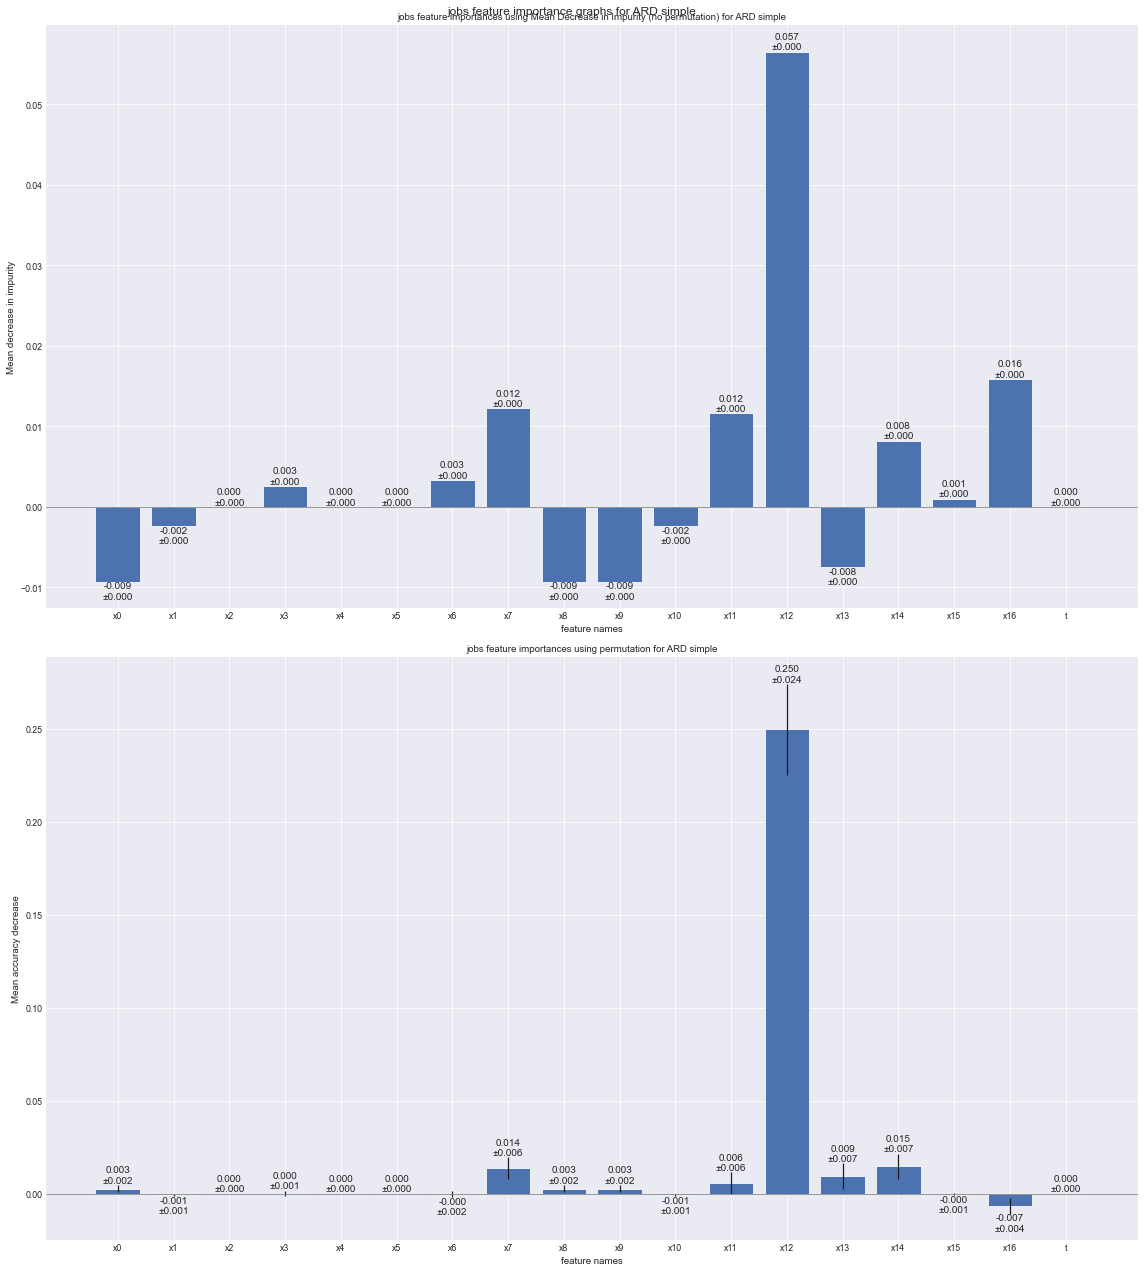

In [ ]:
ard_simple_best.importance_plotter().show()

In [ ]:
%%time

sgd_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple ipsw",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter,
    sample_weights=ipsw_calc
)

-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 180
n_resources: 22
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
----------
iter: 1
n_candidates: 8
n_resources: 22
Fitting 10 folds for each of 8 candidates, totalling 80 fits
best from this iteration: 
GridSearchResults summary sgd simple ipsw jobs
	test score:	-0.10668443571578878
	train score:-0.2672657526271284
	y score:	-0.05938929673369486
	abs ATT:	0.0036918201624084324
	p. risk:	0.007058823529411784

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 32
max_resources_: 1000
aggressive_elimination: True
factor: 32
----------
iter: 0
n_candidates: 180
n_resources: 32
Fitting 10 folds for each of 180 candidates, tota

In [ ]:

sgd_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_ipsw_searched
)

In [ ]:

print(sgd_simple_ipsw_best.info)

sgd_simple_ipsw_best.best_estimator_

GridSearchResults summary sgd simple ipsw jobs
	test score:	-0.10668443571578878
	train score:-0.2672657526271284
	y score:	-0.05938929673369486
	abs ATT:	0.0036918201624084324
	p. risk:	0.007058823529411784
	best params:
		estimator__alpha : 0.0001
		estimator__l1_ratio : 1
		estimator__learning_rate : optimal
		estimator__power_t : 0.25
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDClassifier(early_stopping=True, l1_ratio=1, max_iter=22,
                                penalty='elasticnet', power_t=0.25,
                                random_state=42))])

In [ ]:

sgd_simple_ipsw_best.save_me()

Pickling results to: \jobs\jobs sgd simple ipsw results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs sgd simple ipsw estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs sgd simple ipsw feature importances.pdf


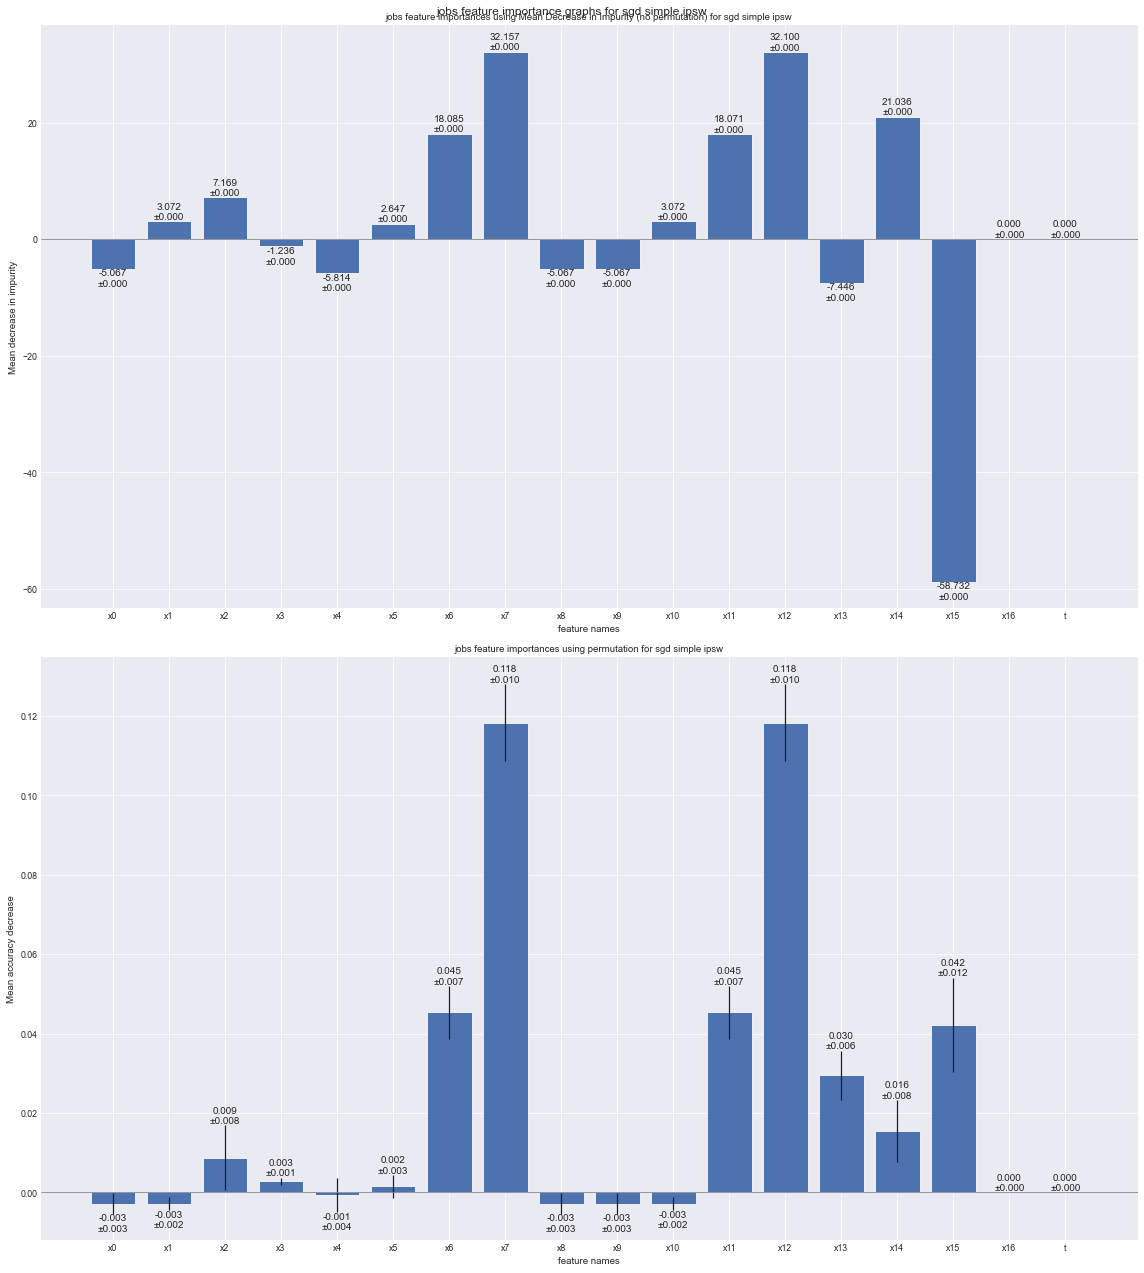

In [ ]:
sgd_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time


ada_rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state=seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_ipsw_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t","y"],
    sample_weights=ipsw_calc,
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 40
n_resources: 1
Fitting 10 folds for each of 40 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 8
n_resources: 5
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest simple with IPSW jobs
	test score:	0.02882794416777712
	train score:0.034015801097927824
	y score:	0.8169258127764352
	abs ATT:	27.493071895424837
	p. risk:	0.2596913108542681

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 50, min: 7, factor: 8
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
fa

In [ ]:

ada_rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_ipsw_searched
)

In [ ]:

print(ada_rf_simple_ipsw_best.info)

ada_rf_simple_ipsw_best.best_estimator_


GridSearchResults summary Adaboost Random Forest simple with IPSW jobs
	test score:	0.09658413410956013
	train score:0.06396129072189612
	y score:	0.711963278768258
	abs ATT:	26.62369578134284
	p. risk:	0.22802157748942997
	best params:
		estimator__base_estimator : RandomForestClassifier(ccp_alpha=0.0012247448713915891, max_features=2,
                       min_impurity_decrease=0.00011066819197003216,
                       min_samples_split=4, n_estimators=14, random_state=42)
		estimator__learning_rate : 0.8
		estimator__n_estimators : 9


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostClassifier(base_estimator=RandomForestClassifier(ccp_alpha=0.0012247448713915891,
                                                                           max_features=2,
                                                                           min_impurity_decrease=0.00011066819197003216,
                                                                           min_samples_split=4,
                                                                           n_estimators=14,
                                                                           random_state=42),
                                     learning_rate=0.8, n_estimators=9,
                                     random_state=42))])

In [ ]:
ada_rf_simple_ipsw_best.save_me()

Pickling results to: \jobs\jobs Adaboost Random Forest simple with IPSW results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Adaboost Random Forest simple with IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Adaboost Random Forest simple with IPSW feature importances.pdf


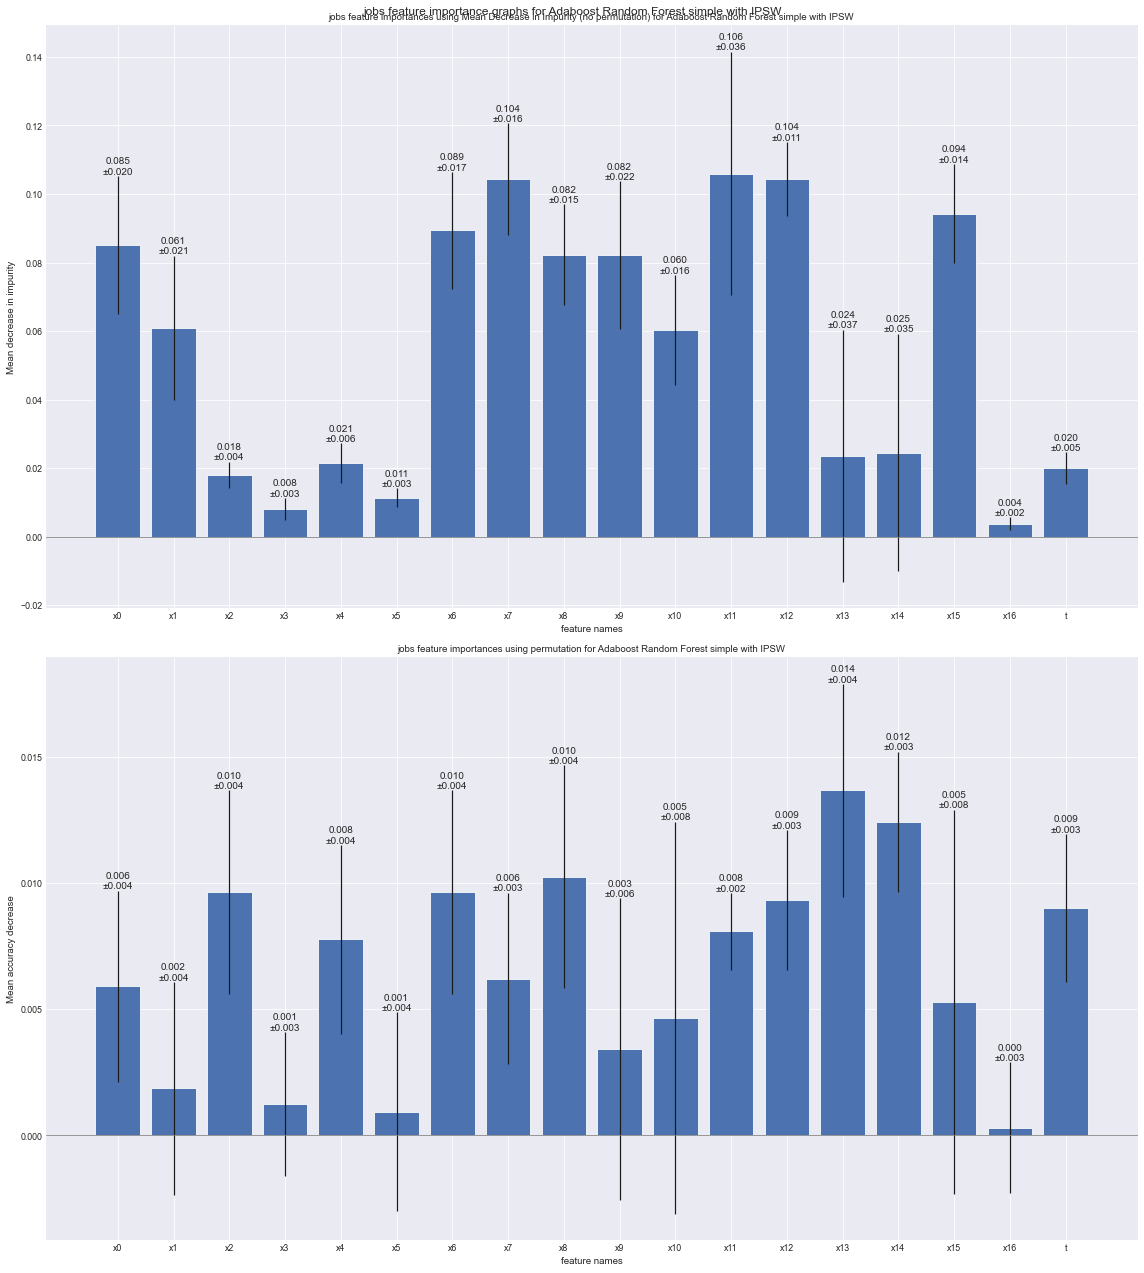

In [ ]:
ada_rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
all_simple_ipsw_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_ipsw_best,
    ard_simple_ipsw_best,
    sgd_simple_ipsw_best,
    ada_rf_simple_ipsw_best
]

all_simple_ipsw_best.sort(reverse=True)

In [ ]:

for bc in all_simple_ipsw_best:
    print(bc.summary_info)

print("")

GridSearchResults summary ARD simple with IPSW jobs
	test score:	0.19529670053455017
	train score:0.2168550319378632
	y score:	0.22053302642612627
	abs ATT:	0.007023840941684956
	p. risk:	0.272259591388771
GridSearchResults summary Adaboost Random Forest simple with IPSW jobs
	test score:	0.09658413410956013
	train score:0.06396129072189612
	y score:	0.711963278768258
	abs ATT:	26.62369578134284
	p. risk:	0.22802157748942997
GridSearchResults summary Random Forest simple with IPSW jobs
	test score:	0.05141334081503812
	train score:0.069318011202359
	y score:	0.11880291216390815
	abs ATT:	0.009205783323430375
	p. risk:	0.0
GridSearchResults summary sgd simple ipsw jobs
	test score:	-0.10668443571578878
	train score:-0.2672657526271284
	y score:	-0.05938929673369486
	abs ATT:	0.0036918201624084324
	p. risk:	0.007058823529411784



In [ ]:
import dill
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")

# 5: The CATE stuff

In [ ]:
from econml.dml import CausalForestDML


import shap

In [ ]:
# obtaining train/test data for the CATE stuff.

X, Y = dfm.x_y(train=True, x_columns=df_utils.DatasetEnum.X_Y)

_, T = dfm.x_y(train=True, x_columns=df_utils.DatasetEnum.X_T)

x_test, y_test = dfm.x_y(train=False, x_columns=df_utils.DatasetEnum.X_Y)

_, t_test = dfm.x_y(train=False, x_columns=df_utils.DatasetEnum.X_T)


In [ ]:
%%time

causal_forest: CausalForestDML = CausalForestDML(
    criterion='het',
    n_estimators=10000,
    min_samples_leaf=10,
    max_depth=None,
    max_samples=0.5,
    discrete_treatment=True,
    honest=True,
    inference=True,
    cv=10,
    random_state=seed(),
    model_t=sklearn.base.clone(best_ipsw_predictor),
    model_y=sklearn.base.clone(best_simple_est),
    verbose=1
)

# fit train data to causal forest model
causal_forest.fit(Y, T, X=X, W=None)
# estimate the CATE with the test set
causal_forest.const_marginal_ate(x_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 10000 out of 

CPU times: total: 1min 39s
Wall time: 44.8 s


[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 10000 out of 10000 | elapsed:    0.8s finished


array([0.01992409])

In [ ]:
slearner.standalone_feature_importance_plotter(
    predictor=causal_forest,
    x_data=x_test,
    y_data=y_test,
    predictor_name="Causal Forest",
    dataset_name=dataset
)

AssertionError: X was not None when fitting, so can't be none for score or effect

In [ ]:
%%time


# fit causal forest with default parameters
#shap_causal_forest = CausalForestDML()
#shap_causal_forest.fit(Y, T, X=X, W=None)

# calculate shap values of causal forest model
shap_values = causal_forest.shap_values(X)
# plot shap values
shap.summary_plot(shap_values['Y0']['T0'])

In [ ]:
import dill
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")